In [ ]:
!nvidia-smi

Sun Jun 20 18:44:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import json
import os
from PIL import Image
import torch
from torchvision import transforms, datasets
import time

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive/")

Mounted at /content/MyDrive/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=35a0c50db129c0e1cc5ae54ffb89320499af08cbd67859baf4d3367a58696df2
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


#Dataset, loader and augmentation

In [ ]:
mean = [0.485, 0.456, 0.406] #[0.485, 0.456, 0.406] mean of resnet #[0.4718, 0.3467, 0.3154] DFDC dataset mean  #RGB #it is the same domain of data so I can use resnet mean and std (I am not sure about the ones calculated for DFDC)
std = [0.229, 0.224, 0.225] #[0.229, 0.224, 0.225] standard deviation of resnet  #[0.1656, 0.1432, 0.1364] std of DFDC
#not sure about those means and std when visualizing

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
data_dir = "/content/MyDrive/MyDrive/PFE_Deepfakes/datasets/DFDC/splited/train_validation_test"

In [ ]:
try:
  train = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
  validation = datasets.ImageFolder(os.path.join(data_dir, "validation"), data_transforms["validation"])
  test = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])
  image_datasets = {
        "train": train,
        "validation": validation,
        "test": test
    }

except RuntimeError:
  print("First try")

except FileNotFoundError:
  print("First try")

First try


In [ ]:
try:
  train = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
  validation = datasets.ImageFolder(os.path.join(data_dir, "validation"), data_transforms["validation"])
  test = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])
  image_datasets = {
        "train": train,
        "validation": validation,
        "test": test
    }

except RuntimeError:
  print("Second try")

except FileNotFoundError:
  print("Second try")

In [ ]:
try:
  train = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
  validation = datasets.ImageFolder(os.path.join(data_dir, "validation"), data_transforms["validation"])
  test = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])
  image_datasets = {
        "train": train,
        "validation": validation,
        "test": test
    }
  print("Done !")

except RuntimeError:
  print("Third try")

except FileNotFoundError:
  print("Third try")

Done !


In [ ]:
def load_gpu(image_datasets, batch_size, data_dir):
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                                 shuffle=True, num_workers=0, pin_memory=True)
                   for x in ['train', 'validation', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
    
    return dataloaders, dataset_sizes

In [ ]:
batch_size = 32 #https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57 / paper : https://arxiv.org/abs/1609.04836
batch_size_512 = 512

dataloaders, dataset_sizes = load_gpu(image_datasets, batch_size, data_dir)
dataloaders_512, dataset_sizes_512 = load_gpu(image_datasets, batch_size_512, data_dir) # works only with the high RAM option
# return batch_size, dataloaders, dataset_sizes

#Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

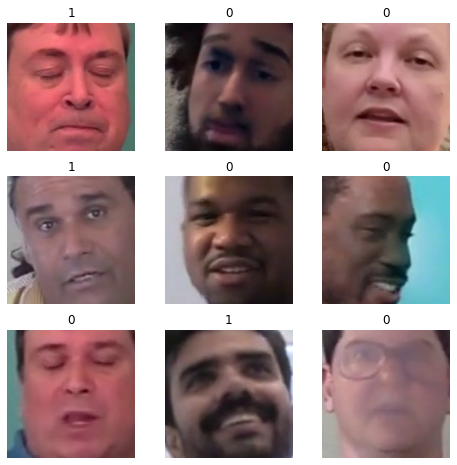

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
training_data = test #image_datasets["train"]
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label) #labels_map[label]
    plt.axis("off")
    inv_tensor = unorm(img)
    #inv_tensor = invTrans(img)
    inv_tensor = inv_tensor.permute(1, 2, 0)
    plt.imshow(inv_tensor.squeeze())
plt.show()

#Model

In [ ]:
from efficientnet_pytorch import EfficientNet
from torch import nn

In [ ]:
#model = EfficientNet.from_pretrained('efficientnet-b3').to(device)
model = EfficientNet.from_name('efficientnet-b3').to(device)
#print(model)

In [ ]:
checkpoint = torch.load('/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/EfficientNet/weigths/EfNet_dfd_epoch_0_batch_5700_2.pth')
model.load_state_dict(checkpoint['model'])
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [ ]:
#X = torch.rand(1, 3, 300, 300, device=device)
#logits = model(X)
#pred_probab = nn.Softmax(dim=1)(logits)
#y_pred = pred_probab.argmax(1)
#print(f"Predicted class: {y_pred}")

#Training

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    since = time.time()
    #batch_start = 1200
    for batch, (x, y) in enumerate(dataloader):
      #if batch > batch_start +50 : 
        x = x.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)
        print(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            time_elapsed = time.time() - since
            print('Those 100 batch took {:.0f}m {:.0f}s to complete'.format(time_elapsed // 60, time_elapsed % 60))
            since = time.time()

            saving_start = time.time()
            save_checkpoint_file_path = "/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/EfficientNet/weigths/EfNet_dfd_epoch_{}_batch_{}_2.pth".format(epoch_start + t, batch)
            checkpoint = { 
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()}
            torch.save(checkpoint, save_checkpoint_file_path)
            saving_time = time.time() - saving_start
            print('This checkpoint {} took {:.0f}m {:.0f}s to be saved'.format(save_checkpoint_file_path, saving_time // 60, saving_time % 60))


def test_loop(dataloader, model, loss_fn):
    #size = len(dataloader.dataset) #does that count the number of elements in the dataset or the number of batches > I think the number of elements instead of the number of batches hence the bug
    #size = len(dataloader.dataset) / batch_size
    test_loss, correct = 0, 0
    i = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            print(loss.item())
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            i+=1

    test_loss /= i
    correct /= i*batch_size_512
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
lr = 1e-4
m= 0.9

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)    

optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)
optimizer.load_state_dict(checkpoint["optimizer"])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr / 10, steps_per_epoch=len(dataloaders["train"]), epochs=10)
scheduler.load_state_dict(checkpoint["scheduler"])

epoch_start = checkpoint["epoch"]
#epoch_start = 0
epochs = 50
for t in range(epochs-epoch_start):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch = t + epoch_start
    train_loop(dataloaders["train"], model, loss_fn, optimizer)
    save_checkpoint_file_path = "/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/EfficientNet/weigths/EfNet_dfd_epoch_{}_completed_2.pth".format(epoch_start + t)
    checkpoint = { 
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()}
    torch.save(checkpoint, save_checkpoint_file_path)
    test_loop(dataloaders["test"], model, loss_fn)
print("Done!")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
0.37224212288856506
0.4558619558811188
0.4367324113845825
0.4879356622695923
0.5283495783805847
0.4552246928215027
0.4158615469932556
0.4657500088214874
0.6090284585952759
0.3362811207771301
0.3718130886554718
0.41689327359199524
0.3190758526325226
0.3168908655643463
0.3742354214191437
0.3783998489379883
0.3284224569797516
0.4416157901287079
0.5412188172340393
0.5622267723083496
0.4913964569568634
0.269661009311676
0.39060962200164795
0.41929906606674194
0.528160572052002
0.5302703976631165
loss: 0.530270  [28800/183761]
Those 100 batch took 24m 8s to complete
This checkpoint /content/MyDrive/MyDrive/PFE_Deepfakes/df_code/EfficientNet/weigths/EfNet_dfd_epoch_0_batch_900_2.pth took 0m 5s to be saved
0.29176199436187744
0.4311380386352539
0.3969327211380005
0.3631018400192261
0.3319510817527771
0.538817286491394
0.29803138971328735
0.27871379256248474
0.44744887948036194
0.5019806623458862
0.40577539801597595
0

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
test_loop(dataloaders_512["test"], model, loss_fn) #increasing the batch size is bad when training but given I have enough GPU it will be quicker when cross_validating
#using batch of 512 only works with the High RAM option   

0.4131423532962799
0.35484567284584045
0.42567944526672363
0.4943689703941345
0.44360050559043884
0.39657455682754517
0.42542004585266113
0.4277436137199402
0.3703307509422302
0.5118653774261475
0.44371646642684937
0.34922608733177185
0.39114826917648315
0.4320589303970337
0.4406947195529938
0.4568733870983124
0.40697115659713745
0.43050074577331543
0.42790281772613525
0.35303130745887756
0.412151038646698
0.4779905080795288
0.41530781984329224
0.3492927849292755
0.3831680715084076
0.5380134582519531
0.452181339263916
0.40464192628860474
0.46101024746894836
0.4193890392780304
0.5084012746810913
0.31624266505241394
0.41523170471191406
0.3594907522201538
0.3622916638851166
0.41455644369125366
0.4396265745162964
0.5109676122665405
Test Error: 
 Accuracy: 41471.1%, Avg loss: 0.421991 



#Comments 

To do : 
- add a scheduler to adapt the lr 
- find what optimizer to use
- Most of the time seems to be dedicated to the loading of the batch and only little on the model > I should try the B7 model to see if it reaaly increases the training time. 
- With the B3 model 100 batches take 10m 20s to be processed on average / Next time it took 25m on average on a V100 ???
- 12800 seems deconnected but not devonnected and activity displayed on the bar on the bottom of the window > it is indeed not connected
-Again a problem where the loss become almost null and the accuracy is perfect on the train and validation dataset while it is garbage on the test dataset
-It seems to bug when I restart a training. Maybe the dataset is not reshuffled and the model is trained on the same images again what makes it overfit. 

Loss : 
*   Epoch 0 : 7.7 > 0.001211 Valid : 100%, 0.000028, test accuracy : 49 % 
*   Epoch 0.5 : 


Test on EfNet_dfd_epoch_0_batch_3400_2.pth

Avg loss is bugged (because it does not take the batch size into account, I must multyply the avg loss by 512 to get the real one here) 

0.5569976568222046
0.5076047778129578
0.5130899548530579
0.5052074790000916
0.5767158269882202
0.5046766400337219
0.535864531993866
0.5372334718704224
0.546810507774353
0.5573053359985352
0.5130075812339783
0.5714015364646912
0.546169102191925
0.551943302154541
0.5511958599090576
0.4736940860748291
0.5709026455879211
0.5688608884811401
0.5406553149223328
0.5470225811004639
0.5221310257911682
0.49721401929855347
0.5528461337089539
0.5466579794883728
0.5273687243461609
0.5143409371376038
0.507239580154419
0.5380761027336121
0.5519888401031494
0.5378734469413757
0.5758343935012817
0.5434485077857971
0.5382033586502075
0.5756165385246277
0.5366977453231812
0.5663970708847046
0.5577203631401062
0.5767300128936768
Test Error: 
 Accuracy: 72.6%, Avg loss: 0.001080 

Epoch 1
-------------------------------
loss: 1.012017  [    0/92463]
Those 100 batch took 0m 16s to complete
This checkpoint took 0m 1s to be saved
loss: 0.025085  [ 3200/92463]
Those 100 batch took 25m 48s to complete
loss: 0.019484  [ 6400/92463]
Those 100 batch took 25m 15s to complete
loss: 0.004387  [ 9600/92463]
Those 100 batch took 25m 5s to complete
This checkpoint took 0m 0s to be saved
loss: 0.002564  [12800/92463]
Those 100 batch took 25m 4s to complete
loss: 0.002878  [16000/92463]
Those 100 batch took 25m 11s to complete
loss: 0.001642  [19200/92463]
Those 100 batch took 25m 8s to complete
This checkpoint took 0m 2s to be saved
loss: 0.002748  [22400/92463]
Those 100 batch took 24m 48s to complete
loss: 0.002070  [25600/92463]
Those 100 batch took 24m 34s to complete
loss: 0.002830  [28800/92463]
Those 100 batch took 24m 34s to complete
This checkpoint took 0m 2s to be saved
loss: 0.039881  [32000/92463]
Those 100 batch took 24m 47s to complete
loss: 0.021064  [35200/92463]
Those 100 batch took 24m 53s to complete
loss: 0.001661  [38400/92463]
Those 100 batch took 24m 36s to complete
This checkpoint took 0m 1s to be saved
loss: 0.000804  [41600/92463]
Those 100 batch took 24m 37s to complete
loss: 0.002600  [44800/92463]
Those 100 batch took 24m 34s to complete
loss: 0.000777  [48000/92463]
Those 100 batch took 24m 34s to complete
This checkpoint took 0m 1s to be saved
loss: 0.000770  [51200/92463]
Those 100 batch took 24m 41s to complete
loss: 0.005708  [54400/92463]
Those 100 batch took 24m 51s to complete
loss: 0.000962  [57600/92463]
Those 100 batch took 24m 54s to complete
This checkpoint took 0m 1s to be saved
loss: 0.003430  [60800/92463]
Those 100 batch took 24m 54s to complete
loss: 0.000745  [64000/92463]
Those 100 batch took 24m 36s to complete
loss: 0.001554  [67200/92463]
Those 100 batch took 24m 33s to complete
This checkpoint took 0m 2s to be saved
loss: 0.000515  [70400/92463]
Those 100 batch took 24m 21s to complete
loss: 0.069868  [73600/92463]
Those 100 batch took 24m 13s to complete
loss: 0.000269  [76800/92463]
Those 100 batch took 24m 14s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000259  [80000/92463]
Those 100 batch took 24m 16s to complete
loss: 0.000347  [83200/92463]
Those 100 batch took 24m 22s to complete
loss: 0.000351  [86400/92463]
Those 100 batch took 24m 25s to complete
This checkpoint took 0m 0s to be saved
loss: 0.001211  [89600/92463]
Those 100 batch took 24m 30s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000028 

Epoch 2
-------------------------------
loss: 0.005103  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000451  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000244  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000424  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000352  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000350  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000176  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000177  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000221  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000175  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000256  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000245  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000272  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000430  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000178  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000202  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000125  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000148  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000277  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000129  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000190  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000321  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000132  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000137  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000151  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000242  [80000/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000149  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000109  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000134  [89600/92463]
Those 100 batch took 0m 39s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000011 

Epoch 3
-------------------------------
loss: 0.000089  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000145  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000108  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000068  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000082  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000131  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000286  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000126  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000120  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000154  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000406  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000099  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000090  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000072  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000067  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000152  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000118  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000141  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000221  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000071  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000066  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000091  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000129  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000061  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000182  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000106  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000090  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000084  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000112  [89600/92463]
Those 100 batch took 0m 38s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000007 

Epoch 4
-------------------------------
loss: 0.000105  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000042  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000074  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000048  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.002209  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000049  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000050  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000069  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000095  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000062  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000242  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000044  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000052  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000148  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000049  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000069  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000069  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000085  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000067  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000058  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000074  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000104  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000108  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000053  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000085  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000068  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000088  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000053  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000057  [89600/92463]
Those 100 batch took 0m 38s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000005 

Epoch 5
-------------------------------
loss: 0.000243  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000056  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000036  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000059  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000045  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000044  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000041  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000084  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000059  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000204  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000046  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000095  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000050  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000068  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000043  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000291  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000371  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000032  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000044  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000097  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000028  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000093  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000037  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000130  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000059  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000069  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000073  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000032  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000030  [89600/92463]
Those 100 batch took 0m 39s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000004 

Epoch 6
-------------------------------
loss: 0.000092  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000038  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000054  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000034  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000056  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000104  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000051  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000162  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000037  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000058  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000065  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000074  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000061  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000046  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000057  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000048  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000030  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000051  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000037  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000079  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000035  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000077  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000029  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000024  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000022  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000029  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000083  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000029  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000032  [89600/92463]
Those 100 batch took 0m 38s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000004 

Epoch 7
-------------------------------
loss: 0.000031  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000048  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000027  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000030  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000022  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000058  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000062  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000055  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000050  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000049  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000031  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000046  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000035  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000031  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000054  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000052  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000023  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000062  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000023  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000027  [60800/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000049  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000038  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000036  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000066  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000020  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000048  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000104  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000016  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000095  [89600/92463]
Those 100 batch took 0m 38s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000003 

Epoch 8
-------------------------------
loss: 0.000079  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000042  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000039  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000996  [ 9600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000027  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000031  [16000/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000031  [19200/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000018  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000022  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000031  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000067  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000029  [35200/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000018  [38400/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000097  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000023  [44800/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000028  [48000/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000019  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000019  [54400/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000051  [57600/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000033  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000021  [64000/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000043  [67200/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000021  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000019  [73600/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000048  [76800/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000016  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000016  [83200/92463]
Those 100 batch took 0m 37s to complete
loss: 0.000026  [86400/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000031  [89600/92463]
Those 100 batch took 0m 38s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000003 

Epoch 9
-------------------------------
loss: 0.000102  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000036  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000037  [ 6400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000038  [ 9600/92463]
Those 100 batch took 0m 37s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000048  [12800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000024  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000026  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000027  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000027  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000043  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000025  [32000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000034  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000025  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000019  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000041  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000021  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000070  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000029  [54400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000025  [57600/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000021  [60800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000020  [64000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000024  [67200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000026  [70400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000014  [73600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000020  [76800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000039  [80000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000036  [83200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000032  [86400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000025  [89600/92463]
Those 100 batch took 0m 38s to complete
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000003 

Epoch 10
-------------------------------
loss: 0.000022  [    0/92463]
Those 100 batch took 0m 0s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000017  [ 3200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000026  [ 6400/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000025  [ 9600/92463]
Those 100 batch took 0m 39s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000023  [12800/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000041  [16000/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000048  [19200/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000028  [22400/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000029  [25600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000023  [28800/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000014  [32000/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000024  [35200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000028  [38400/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000027  [41600/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000068  [44800/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000023  [48000/92463]
Those 100 batch took 0m 38s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000021  [51200/92463]
Those 100 batch took 0m 38s to complete
loss: 0.000023  [54400/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000011  [57600/92463]
Those 100 batch took 0m 39s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000030  [60800/92463]
Those 100 batch took 0m 40s to complete
loss: 0.000032  [64000/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000216  [67200/92463]
Those 100 batch took 0m 40s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000024  [70400/92463]
Those 100 batch took 0m 42s to complete
loss: 0.000028  [73600/92463]
Those 100 batch took 0m 40s to complete
loss: 0.000027  [76800/92463]
Those 100 batch took 0m 40s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000024  [80000/92463]
Those 100 batch took 0m 39s to complete
loss: 0.000020  [83200/92463]
Those 100 batch took 0m 40s to complete
loss: 0.000030  [86400/92463]
Those 100 batch took 0m 40s to complete
This checkpoint took 0m 0s to be saved
loss: 0.000017  [89600/92463]
Those 100 batch took 0m 41s to complete

#Tests

In [ ]:
for batch, (x, y) in enumerate(dataloaders["train"]):
  print("batch")
  print(batch)
  print("x")
  print(x)
  print("y")
  print(y)

In [ ]:
cd /content/MyDrive/MyDrive/PFE_Deepfakes/df_code/EfficientNet/weigths

/content
